aa# MFHT Grid Plot
plt.close('all')

In [1]:
import sqlite3

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import datetime

import sys
sys.path.append('../stabilvol')
from utility.functions import stringify_threshold

from pathlib import Path
ROOT = Path('../')
DATABASE = '../data/processed/trapezoidal_selection/stabilvol_filtered.sqlite'

MARKETS = ["UN", "UW", "LN", "JT"]
START_LEVELS = [
    -2.0, 
    # -1.0, -0.5, 
    -0.2, -0.1, 0.1, 0.2, 
    # 0.5, 1.0, 
    2.0
    ]
DELTAS = [
    2.0, 
    # 1.0, 0.5, 
    0.2, 0.1, -0.1, -0.2, 
    # -0.5, -1.0, 
    -2.0
    ]
LEVELS = {
    (start, round(start+delta, 2)) for start in START_LEVELS for delta in DELTAS
}
LEVELS = sorted(LEVELS)

VOL_LIMIT= 0.5  # Change this will change all the pickle files, remember to re-generate them
FILTERED = True  # Change this will change all the pickle files, remember to re-generate them

FILE_DIR = ROOT / f'data/processed/trapezoidal_selection/vol0{str(VOL_LIMIT).replace(".", "")}'

len(LEVELS)

36

In [2]:
# Connect to the SQLite database
conn = sqlite3.connect(DATABASE)
cur = conn.cursor()

In [3]:
def select_bins(df, max_n=1000):
    nbins = 50
    
    while True:
        # Use qcut to bin 'Volatility' values
        df['Bins'] = pd.qcut(df['Volatility'], nbins, duplicates='drop')
        
        # Group by the bins and calculate the mean and standard error of 'value'
        grouped = df.groupby('Bins', observed=False)['FHT'].agg(['mean', error_on_the_mean, 'size'])
        count = grouped['size'].min()
        
        if count < max_n or nbins > 1000:
            break
        else:
            nbins += 20
    return grouped, nbins

def error_on_the_mean(values):
    return np.std(values)/np.sqrt(len(values))

In [4]:
def query_binned_data(
        market: str, start_date:str, end_date:str = None, vol_limit:float = 0.5, t1_string:str = "m0p5", t2_string:str = "m1p5"):
    grouped_data = None
    end_date = '2022-07-01' if end_date is None else end_date
    try:            
        # Write the SQL query
        query = f'''
        SELECT *
        FROM stabilvol_{t1_string}_{t2_string}
        WHERE Volatility < {vol_limit} 
        AND Market = "{market}"
        AND start > "{start_date}"
        AND end < "{end_date}"    
        '''
        # Load the FHT data from the database
        df = pd.read_sql_query(query, conn)
    except pd.errors.DatabaseError:
        print(f'No data for market {market} with thresholds {t1_string}-{t2_string}')
        nbins = 0
    else:
        grouped_data, nbins = select_bins(df)
    return grouped_data, nbins

def save_all_mfhts(market, save=True):
    bins_dict = {}
    for t1, t2 in tqdm(LEVELS):
        # Create the strings for the threshold values
        t1_string = stringify_threshold(t1)
        t2_string = stringify_threshold(t2)
        # Filename for the MFHT data
        filename = f'../data/processed/trapezoidal_selection/mfht_{market}_{t1_string}_{t2_string}.pkl'
           
        if save and not os.path.exists(filename):
            # Load the dataframe from the database if it exists
            grouped_data, nbins = query_binned_data(market, t1_string, t2_string, VOL_LIMIT)
            grouped_data.to_pickle(filename)
        else:
            print(f"File '{filename}' already exists")
            nbins = 0
        bins_dict[(t1, t2)] = nbins  
            
    return bins_dict

In [5]:
# Try if it works
df, _ = query_binned_data("UN", "1996-04-05")
df.head()

,mean,error_on_the_mean,size
Bins,,,
"(-0.001, 0.00132]",2.337234,0.068715,940
"(0.00132, 0.00265]",2.294995,0.060161,939
"(0.00265, 0.00393]",2.427050,0.045029,939
"(0.00393, 0.00498]",2.697551,0.065529,939
"(0.00498, 0.00595]",2.806177,0.051787,939


## Shrinking Window
We take the start date closer to the end date to see if the nonmonotic behaviour vanishes

In [6]:
plt.rcParams.update({'text.usetex': False})

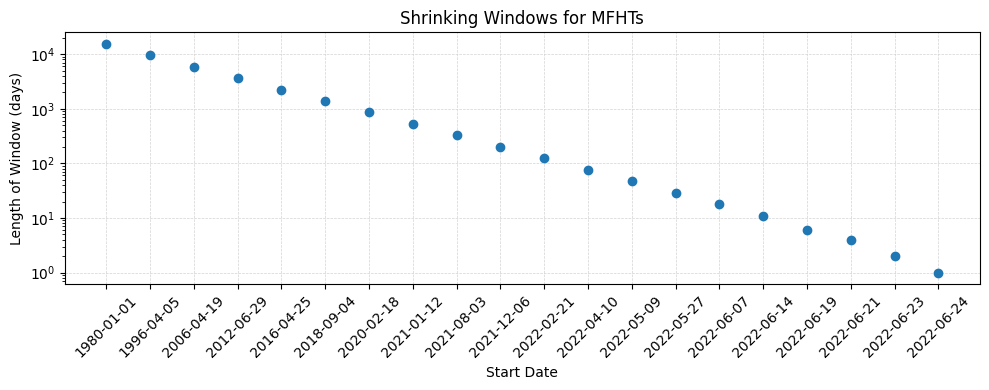

There are 20 dates starting from 1980-01-01 to 2022-06-24


In [7]:
def plot_dates(dates, end_date, save=False):
    fig, ax = plt.subplots(figsize=(10, 4), layout='tight')
    ax.grid(c='lightgrey', linestyle='--', linewidth=0.5)
    ax.set_yscale('log')
    ax.set_title('Shrinking Windows for MFHTs')
    # Plot the dates on the x-axis and the number of bins on the y-axis
    x = [d.strftime('%Y-%m-%d') for d in dates]
    y = [(end_date - d).days for d in dates]
    ax.scatter(x, y, zorder=10)
    
    # Set the x-axis label and title
    ax.set_xlabel('Start Date')
    ax.set_ylabel('Length of Window (days)')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    if save:
        fig.savefig(f'../visualization/dynamics/dates_of_shrinking_windows.png', bbox_inches='tight')
        fig.savefig(f'../visualization/dynamics/dates_of_shrinking_windows.pdf', bbox_inches='tight', transparent=True)

    # Show the plot
    plt.show()

def create_dates(plot=True, save_plot=False):
    # Define the start and end dates
    start_date = datetime.date(1980, 1, 1)
    end_date = datetime.date(2022, 6, 25)
    
    # Calculate the number of days between the start and end dates
    total_days = (end_date - start_date).days
    
    # Generate a logarithmically spaced sequence of numbers between 1 and the total number of days
    log_days = np.logspace(0, np.log10(total_days), num=21, base=10.0)
    # Convert to integers to remove duplicates, then sort
    log_days = sorted(set(map(int, log_days)), reverse=True)
    
    # Convert the logarithmically spaced numbers to dates
    dates = [end_date - datetime.timedelta(days=int(d)) for d in log_days]
    if plot:
        plot_dates(dates, end_date, save_plot)
    return dates

    
dates = create_dates(plot=True, save_plot=True)
print(f"There are {len(dates)} dates starting from {dates[0]} to {dates[-1]}")

In [8]:
def plot_mfhts(market, mfht, ax, **kwargs):
    x = mfht.index.categories.left.values
    # Renormalize the first value
    x[0] = 0
    y = mfht['mean'].values
    
    line, = ax.plot(x, y, lw=1, label=kwargs.get('label', None))
    
    if kwargs.get('error', True):
        y_err = mfht['error_on_the_mean'].values     
        ax.fill_between(x, y - y_err, y + y_err, alpha=0.2)

    ax.set_title(market, fontsize=18)
    
    ax.set_xlim(kwargs.get('xlim', (-0.001, 0.08)))
    
    ax.set_yscale(kwargs.get('yscale', 'linear'))
    
    ax.grid(True)
    return ax

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_inset(mfht, inset_ax):
    mfht.dropna(inplace=True)    
    x = [cat.left for cat in mfht.index.tolist()]
    y = mfht['mean'].values
    
    # Now you can plot on the inset axes
    inset_ax.plot(x, y)
    return inset_ax

JT: 100%|██████████| 20/20 [00:02<00:00,  7.03it/s]


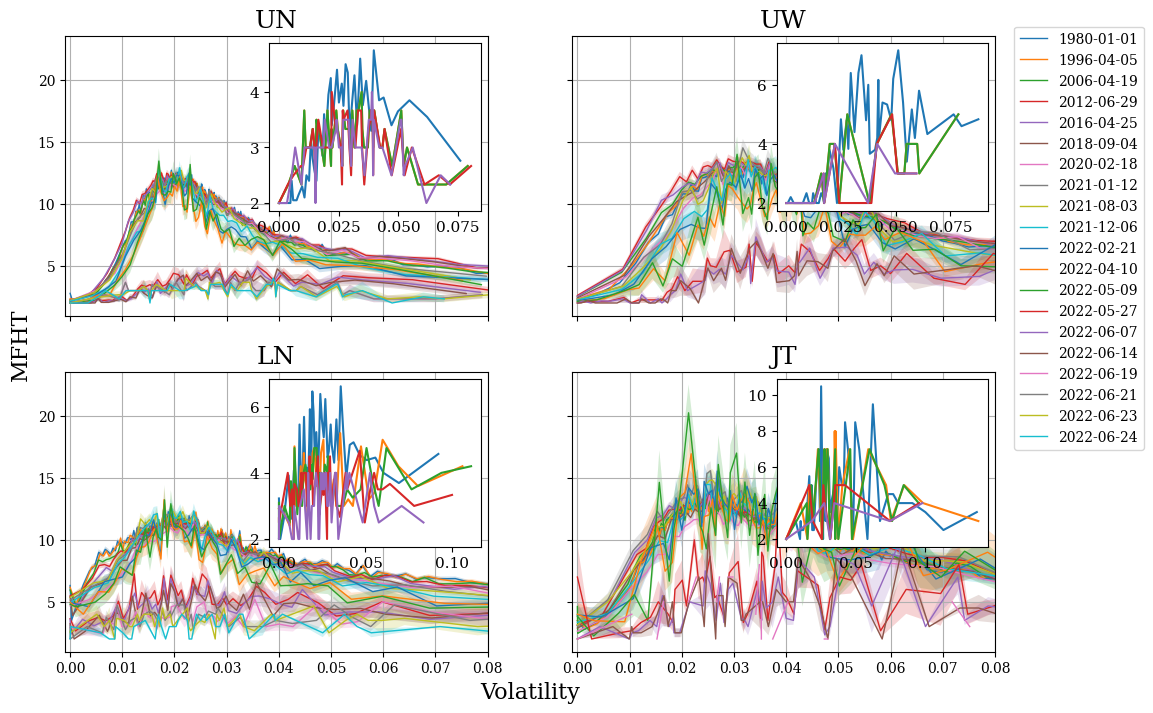

In [9]:
def plot_shrinking_windows(dates, dates_inset=10, show=True, save=False, latex=False):
    plt.rcParams.update({'text.usetex': latex, 'font.family': 'serif'})
    fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharey=True, sharex=True)

    axs[0, 0].set_ylabel('MFHT', y=-0.1 ,fontsize=16)
    axs[1, 0].set_xlabel('Volatility', x=1.1, fontsize=16)

    for i, (market, ax) in enumerate(zip(MARKETS, axs.flatten())):
        # Place the inset axes
        inset_ax = inset_axes(ax, width="50%", height="60%", loc=1) 
        inset_ax.tick_params(axis='both', which='major', labelsize=11)
        for start_date in tqdm(dates, desc=market):
            mfht, nbins = query_binned_data(market, start_date, vol_limit=VOL_LIMIT)
            
            if mfht.empty:
                print(f"No data for {market} with start date {start_date}")
                continue
            
            ax = plot_mfhts(market, mfht, ax, label=start_date)
            
            if start_date in dates[-dates_inset:]:
                inset_ax = plot_inset(mfht, inset_ax)
            if i==0:
                handles, labels = ax.get_legend_handles_labels()
    
    # Create a single legend outside all subplots
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.03, 0.9), markerscale=2.0)

    # fig.tight_layout()
    if save:
        fig.savefig(f'../visualization/dynamics/shrinking_windows.png', bbox_inches='tight')
        fig.savefig(f'../visualization/dynamics/shrinking_windows.pdf', bbox_inches='tight', transparent=True)
    if show:
        plt.show()
    else:
        return fig
    
plot_shrinking_windows(dates, 5, save=True)

### Focus on the last shorter windows

210, 190, 150, 90, 70, 70, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 

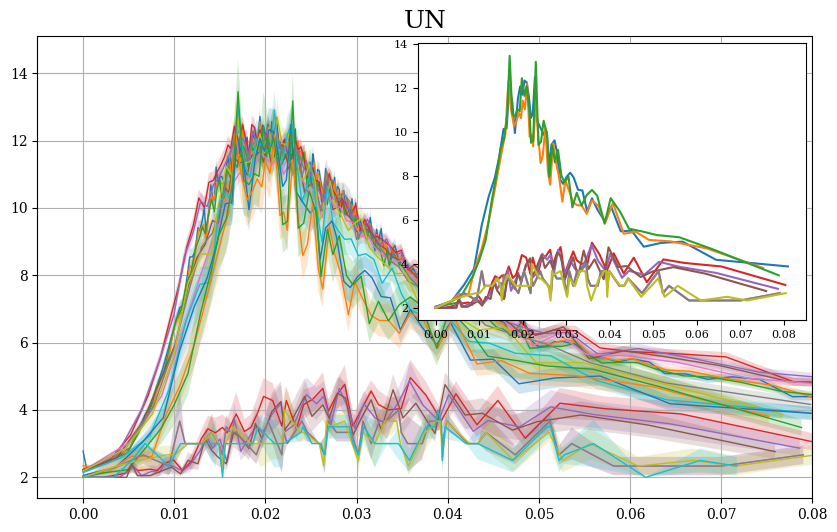

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
market = "UN"
# Assuming 'ax' is your existing axes object
inset_ax = inset_axes(ax, width="50%", height="60%", loc=1)  # loc parameter is the location of the inset axes
# You may also want to adjust the ticks
inset_ax.tick_params(axis='both', which='major', labelsize=8)
for start_date in dates:
        mfht, nbins = query_binned_data(market, start_date, vol_limit=VOL_LIMIT)
        if mfht.empty:
              continue
        
        print(nbins, end=', ')
        ax = plot_mfhts(market, mfht, ax, xlim=(-0.005, 0.08))
        
        if start_date in dates[-10:-1]:            
            plot_inset(mfht, inset_ax)
        

# 2008 Crisis
Please note that we need to establish clear key dates:
15th September 2008 bankruptcy filing of LB
\url{https://en.wikipedia.org/wiki/Lehman\_Brothers}

but troubles started much earlier with the subprime mortgage crisis, so we need to look at when housing market prices crashed.

Note: "In August 2007, the firm closed its subprime lender, BNC Mortgage, eliminating 1,200 positions in 23 locations, and took an after-tax charge of \$25 million and a \$27 million reduction in goodwill. Lehman said that poor market conditions in the mortgage space "necessitated a substantial reduction in its resources and capacity in the subprime space."

In September 2007, Joe Gregory appointed Erin Callan as CFO. On March 16, 2008, after rival Bear Stearns was taken over by JP Morgan Chase in a fire sale, market analysts suggested that Lehman would be the next major investment bank to fall. Callan fielded Lehman's first quarter conference call, where the firm posted a profit of \$489 million, compared to Citigroup's \$5.1 billion and Merrill Lynch's \$1.97 billion losses which was Lehman’s 55th consecutive profitable quarter. The firm's stock price leapt 46 percent after that announcement." 

Also note that March 2007 marks the beginning of the subprime crisis with the largest drop in house prices in a decade.

In [ ]:
CRISIS2007 = datetime.date(2007, 3, 15)
CRISIS2008 = datetime.date(2008, 9, 15)

In [ ]:
def create_dates(center_date, nwindows=20):
    # Define the maximum duration (28 years in days)
    max_duration = 28 * 365
    
    # Generate durations that decrease logarithmically
    durations = np.logspace(1.4, np.log10(max_duration), num=nwindows, base=10.0)
    durations = sorted(set(map(int, durations)), reverse=True)
    
    # Generate the windows
    return [(center_date - datetime.timedelta(days=int(d))/2, center_date + datetime.timedelta(days=int(d))/2) for d in durations]

In [ ]:
def plot_shrinkingmfht(windows, vol_limit = VOL_LIMIT):
    # Use LaTeX for text rendering
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.family'] = 'serif'
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharey=True, sharex=True)
    
    axs[0, 0].set_ylabel('MFHT', y=-0.1 ,fontsize=16)
    axs[1, 0].set_xlabel('Volatility', x=1.1, fontsize=16)
    
    for i, (market, ax) in enumerate(zip(MARKETS, axs.flatten())):
        # Place the inset axes
        inset_ax = inset_axes(ax, width="50%", height="60%", loc=1) 
        inset_ax.tick_params(axis='both', which='major', labelsize=11)
        for start_date, end_date in tqdm(windows, desc=market):
            duration = end_date - start_date 
            
            mfht, nbins = query_binned_data(market, start_date, end_date, vol_limit)
            
            ax = plot_mfhts(market, mfht, ax, error=False, label=duration.days)
            
            if duration < pd.to_timedelta('90d'):
                inset_ax = plot_inset(mfht, inset_ax)
    
    # fig.tight_layout()
    # Add common legend on top
    handles, labels = axs[0, 0].get_legend_handles_labels()  # get the handles and labels from any subplot
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4)  # place the legend outside the plot area
    plt.show()

### March 2007

JT: 100%|██████████| 16/16 [00:03<00:00,  5.29it/s]


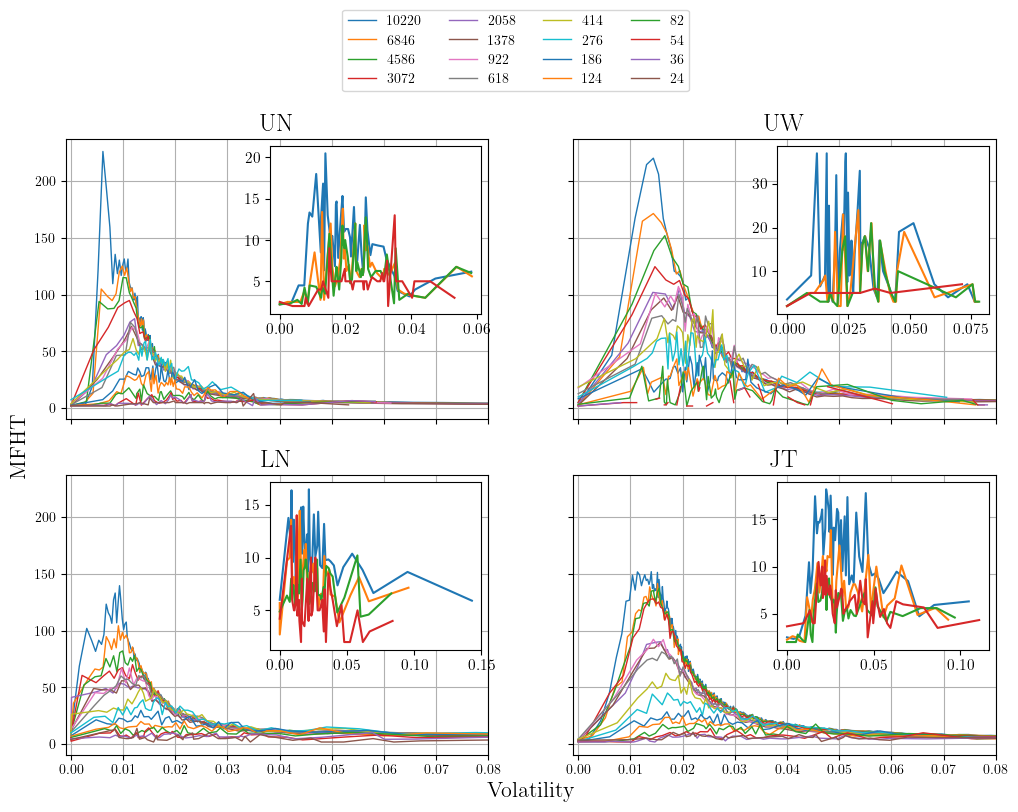

In [ ]:
windows = create_dates(CRISIS2007, 16)

plot_shrinkingmfht(windows)

### September 2008

JT: 100%|██████████| 16/16 [00:03<00:00,  5.02it/s]


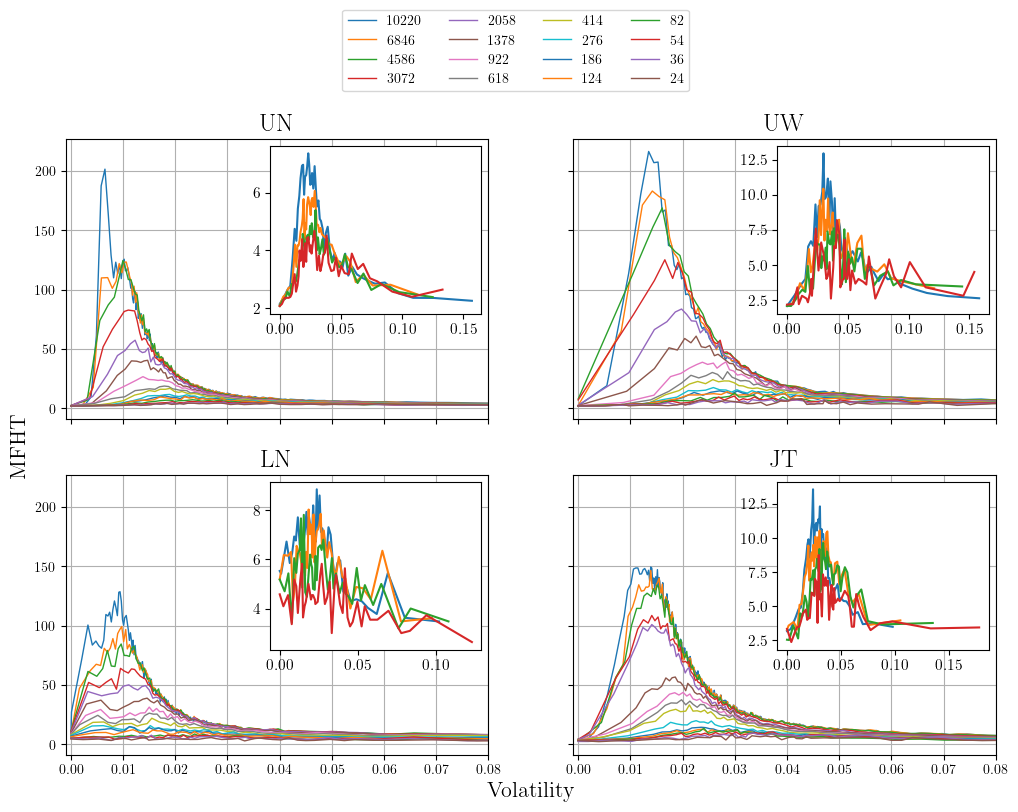

In [ ]:
windows = create_dates(CRISIS2008, 16)

plot_shrinkingmfht(windows)

### Before the Crisis

JT: 100%|██████████| 12/12 [00:02<00:00,  5.61it/s]


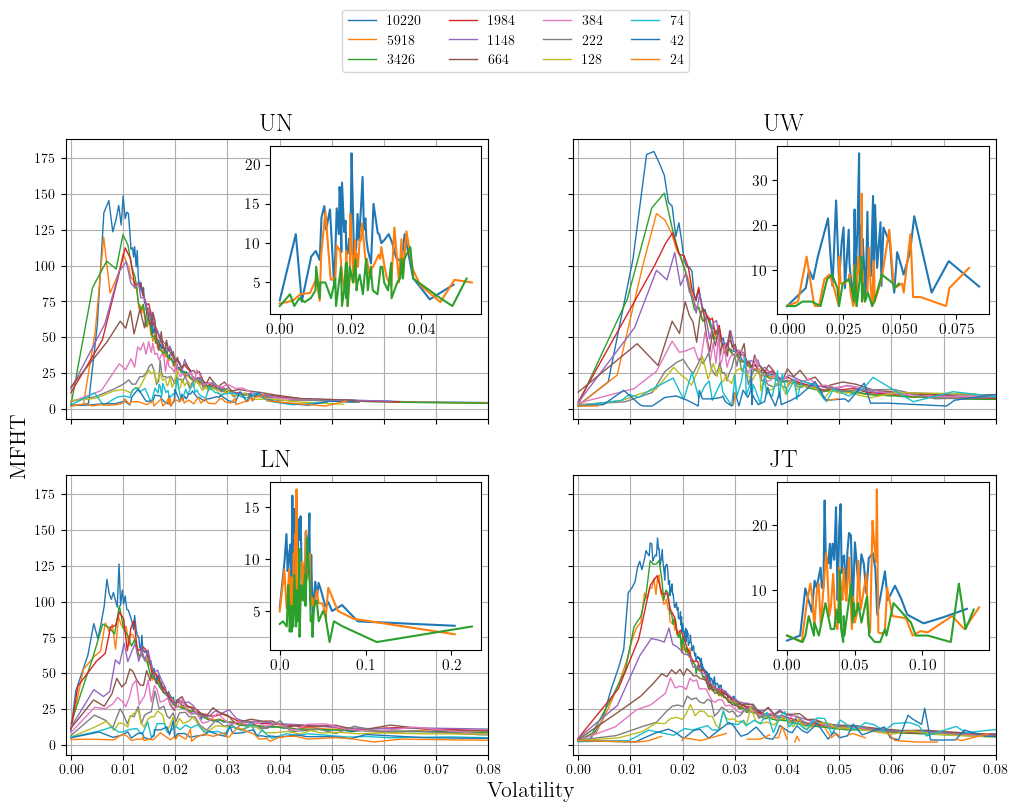

In [ ]:
nyears = 3 # Number of years before the crisis
windows = create_dates(CRISIS2007 - datetime.timedelta(days=nyears*365), 12)

plot_shrinkingmfht(windows)

### After the Crisis

JT: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


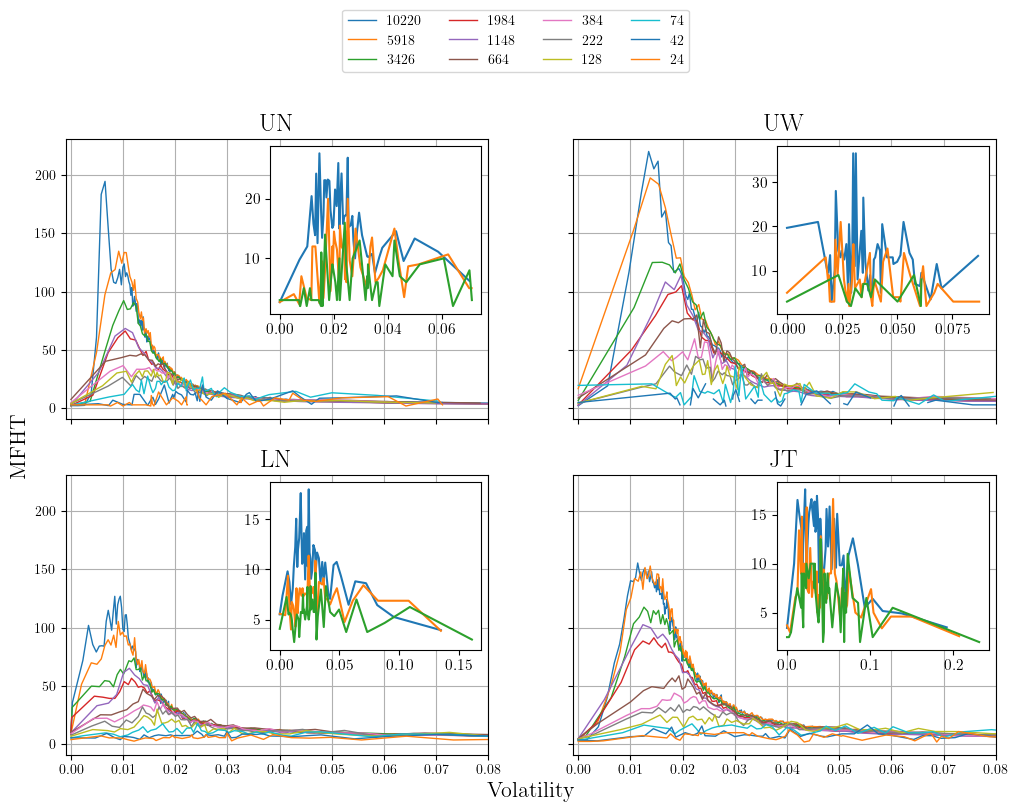

In [ ]:
nyears = -3 # Number of years before the crisis
windows = create_dates(CRISIS2007 - datetime.timedelta(days=nyears*365), 12)

plot_shrinkingmfht(windows)

Apparently nothing important changes.